### Import Libraries / Process data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform, truncnorm, randint, binom
from sklearn.utils import class_weight
from sklearn import preprocessing
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_curve, auc, precision_score, confusion_matrix,\
 ConfusionMatrixDisplay, recall_score, accuracy_score, f1_score, classification_report, make_scorer
import pickle
import matplotlib.pyplot as plt

In [2]:
# Preprocess data
def process_data(name):
    file = r'../data/' + name + '.csv'
    print("processing file: {}".format(file))
    file = pd.read_csv(file,dtype=object)
    file.drop(columns=['land','Last_Update','province','country'],inplace=True)
    file['source'] = file['source'].fillna(value='')
    return file
file = process_data("cases_train_preprocessed")

processing file: ../data/cases_train_preprocessed.csv


### Catboost model data preparation 

In [3]:
# Train / Test split for model evaluation
def catboost_data(file):
    cat_feature=['sex','source','age_range_ind','age_range']
    text_feature = ['additional_information']

    df_tr, df_va = train_test_split(file, test_size=0.2, random_state = 1)

    df_tr_x = df_tr.drop(columns="outcome")
    df_tr_y = df_tr['outcome']

    df_tr_data = Pool(data = df_tr_x,
                   label = df_tr_y,
                   cat_features = cat_feature, 
                   text_features=text_feature)

    df_va_x = df_va.drop(columns="outcome")
    df_va_y = df_va['outcome']

    df_va_data = Pool(data = df_va_x,
                   label = df_va_y,
                   cat_features = cat_feature, 
                   text_features=text_feature)
    return df_tr_x, df_tr_y, df_va_x, df_va_y
tr, tr_y, va, va_y = catboost_data(file)

### Parameter Tuning - Randomized Search 

In [ ]:
# Specifying possible parameters of catboost - Random Search 
grid = {'learning_rate': uniform(0.2, 0.6),
        'depth': randint(5,8),
        'n_estimators':randint(100, 400)
       }

# Bk-2
# grid = {'learning_rate': uniform(0.2, 0.8),
#         'depth': randint(6,12),
#         'l2_leaf_reg': uniform(0.0, 0.25),
#         'n_estimators':randint(100, 600)
#        }

# Specify catboost parameters
cat_feature=['sex','source','age_range_ind','age_range']
text_feature = ['additional_information']

# Creating required scoring function
scorer = {
    'f1_macro' : make_scorer(f1_score, average='macro'),
    'recall_macro': make_scorer(recall_score , average='macro'),
    'accuracy': make_scorer(accuracy_score),
    'recall_d' : make_scorer(recall_score,average=None,labels=['deceased']),
    'f1_d' : make_scorer(f1_score, average=None, labels=['deceased']),
}

# Creating Catboost model - bk1
# model = CatBoostClassifier( task_type="CPU",
#                             devices='0:1',
#                             loss_function='MultiClass',
#                             auto_class_weights = 'SqrtBalanced',
#                             cat_features = cat_feature,
#                             text_features = text_feature,
#                             verbose = 100)

model = CatBoostClassifier( task_type="CPU",
                            devices='0:1',
                            loss_function='MultiClass',
                           auto_class_weights = 'Balanced',
                            cat_features = cat_feature,
                            text_features = text_feature,
                            verbose = 100)

clf_rand = RandomizedSearchCV(estimator=model, n_iter=60, param_distributions=grid, scoring=scorer, cv= 3, refit="f1_d", n_jobs=4, verbose=1)
model = clf_rand.fit(tr, tr_y)


Fitting 3 folds for each of 60 candidates, totalling 180 fits


### Saving model params and putting attempted parameters into csv

In [ ]:
# Saving Model Params
filename = '../models/catboost_classifier.pkl'
pickle.dump(model, open(filename, 'wb'))
print(clf_rand.best_params_)

In [ ]:
# Output attempted parameters and resulting metrics
df = pd.DataFrame(clf_rand.cv_results_ )
df = df.sort_values(by='rank_test_f1_d')
df = df[df.columns.drop(list(df.filter(regex=r'(time)|(std)|(split)|(param_)|(rank)')))]
df = df[['params', 'mean_test_f1_d', 'mean_test_recall_d', 'mean_test_accuracy', 'mean_test_recall_macro','mean_test_f1_macro']]
df.rename(columns={"mean_test_f1_macro": "Overall F1-Score(Macro)", 
                   "mean_test_recall_macro": "Overall Recall(Macro)",
                   "mean_test_accuracy": "Overall Accuracy",
                   "mean_test_f1_d": "F1-Score on Deceased",
                   "mean_test_recall_d": "Recall on Deceased",
                   "params": "Hyperparameters"
                  },inplace=True)
df.to_csv('../results/catboost_tuning.csv',index=False)

### Loading trained model using best params from randomized search

In [ ]:
filename = '../models/catboost_classifier.pkl'
tuned_model = pickle.load(open(filename, 'rb'))

In [ ]:
label = ['hospitalized', 'nonhospitalized','recovered', 'deceased']
tr_pred = tuned_model.predict(tr)
ev_tr_report = classification_report(tr_y, tr_pred)
ev_tr_accuracy = accuracy_score(tr_y, tr_pred)
ev_tr_matrix = confusion_matrix(tr_y, tr_pred,labels=label)
print(ev_tr_report)
ConfusionMatrixDisplay(ev_tr_matrix).plot()

In [ ]:
label = ['hospitalized', 'nonhospitalized','recovered', 'deceased']
va_pred = tuned_model.predict(va)
ev_va_report = classification_report(va_y, va_pred)
ev_va_accuracy = accuracy_score(va_y, va_pred)
ev_va_matrix = confusion_matrix(va_y, va_pred,labels=label)
print(ev_va_report)
ConfusionMatrixDisplay(ev_va_matrix).plot()

### Prediction on test set

In [3]:
# Preprocess data
def process_data(name):
    file = r'../data/' + name + '.csv'
    print("processing file: {}".format(file))
    file = pd.read_csv(file,dtype=object)
    file.drop(columns=['Last_Update','province','country', 'outcome'],inplace=True)
    file['source'] = file['source'].fillna(value='')
    return file
file = process_data("cases_test_preprocessed")
print('file len:',len(file))

processing file: ../data/cases_test_preprocessed.csv
file len: 46500


In [4]:
# Test data preparation
def catboost_data(file):
    te_x = file
    return te_x
te_x = catboost_data(file)

In [11]:
filename = '../models/catboost_classifier_bk1.pkl'
tuned_model = pickle.load(open(filename, 'rb'))

In [12]:
# cat_feature=['sex','source','age_range_ind','age_range']
# text_feature = ['additional_information']

label = ['hospitalized', 'nonhospitalized','recovered', 'deceased']
dest = '../results/predictions.txt'
te_pred = tuned_model.predict(te_x)
te_pred = pd.DataFrame(te_pred, columns = ['outcome'])
te_pred.to_csv(dest,index=False,header=False)
file_data = open(dest, 'rb').read()
open(dest, 'wb').write(file_data[:-2])
print('te_pred len:',len(te_pred))
counted = Counter(te_pred['outcome'])
counted

te_pred len: 46500


Counter({'nonhospitalized': 19966,
         'hospitalized': 15850,
         'recovered': 10188,
         'deceased': 496})

In [7]:
# Check if prediction file is valid
def check_if_file_valid(filename):
    assert filename.endswith('predictions.txt'), 'Incorrect filename'
    f = open(filename).read()
    l = f.split('\n')
    assert len(l) == 46500, 'Incorrect number of items'
    assert (len(set(l)) == 4), 'Wrong class labels'
    return 'The predictions file is valid'
check_if_file_valid('../results/predictions.txt')

'The predictions file is valid'

In [8]:
dest = '../results/predictions.txt'
result = pd.read_csv(dest, header = None, names=['outcome'])
counted = Counter(result['outcome'])
print('result len:',len(result))
counted

result len: 46500


Counter({'nonhospitalized': 19966,
         'hospitalized': 15850,
         'recovered': 10188,
         'deceased': 496})

### Loading trained model using best params from randomized search - BK1

In [4]:
filename = '../models/catboost_classifier_bk1.pkl'
tuned_model = pickle.load(open(filename, 'rb'))

                 precision    recall  f1-score   support

       deceased       0.45      0.23      0.31      3583
   hospitalized       0.81      0.84      0.83     99933
nonhospitalized       0.99      0.99      0.99    119402
      recovered       0.75      0.74      0.74     70362

       accuracy                           0.87    293280
      macro avg       0.75      0.70      0.72    293280
   weighted avg       0.87      0.87      0.87    293280



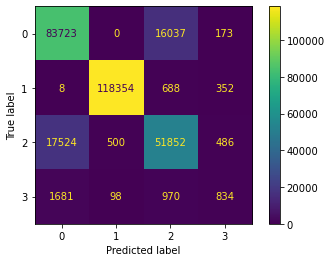

In [5]:
label = ['hospitalized', 'nonhospitalized','recovered', 'deceased']
tr_pred = tuned_model.predict(tr)
ev_tr_report = classification_report(tr_y, tr_pred)
ev_tr_accuracy = accuracy_score(tr_y, tr_pred)
ev_tr_matrix = confusion_matrix(tr_y, tr_pred,labels=label)
print(ev_tr_report)
ConfusionMatrixDisplay(ev_tr_matrix).plot()

                 precision    recall  f1-score   support

       deceased       0.43      0.22      0.29       912
   hospitalized       0.81      0.84      0.82     24862
nonhospitalized       0.99      0.99      0.99     30018
      recovered       0.75      0.73      0.74     17528

       accuracy                           0.87     73320
      macro avg       0.75      0.70      0.71     73320
   weighted avg       0.87      0.87      0.87     73320



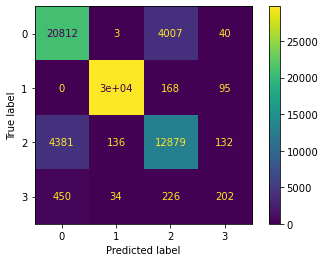

In [6]:
label = ['hospitalized', 'nonhospitalized','recovered', 'deceased']
va_pred = tuned_model.predict(va)
ev_va_report = classification_report(va_y, va_pred)
ev_va_accuracy = accuracy_score(va_y, va_pred)
ev_va_matrix = confusion_matrix(va_y, va_pred,labels=label)
print(ev_va_report)
ConfusionMatrixDisplay(ev_va_matrix).plot()

### Loading trained model using best params from randomized search - BK2

In [7]:
filename = '../models/catboost_classifier_bk2.pkl'
tuned_model = pickle.load(open(filename, 'rb'))

                 precision    recall  f1-score   support

       deceased       0.42      0.24      0.30      3583
   hospitalized       0.81      0.82      0.82     99933
nonhospitalized       0.99      0.99      0.99    119402
      recovered       0.73      0.73      0.73     70362

       accuracy                           0.86    293280
      macro avg       0.74      0.70      0.71    293280
   weighted avg       0.86      0.86      0.86    293280



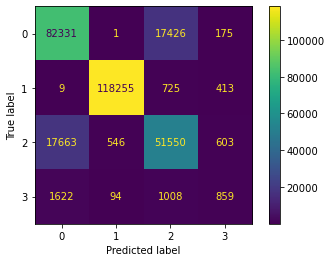

In [8]:
label = ['hospitalized', 'nonhospitalized','recovered', 'deceased']
tr_pred = tuned_model.predict(tr)
ev_tr_report = classification_report(tr_y, tr_pred)
ev_tr_accuracy = accuracy_score(tr_y, tr_pred)
ev_tr_matrix = confusion_matrix(tr_y, tr_pred,labels=label)
print(ev_tr_report)
ConfusionMatrixDisplay(ev_tr_matrix).plot()

                 precision    recall  f1-score   support

       deceased       0.39      0.22      0.28       912
   hospitalized       0.81      0.82      0.81     24862
nonhospitalized       0.99      0.99      0.99     30018
      recovered       0.72      0.73      0.73     17528

       accuracy                           0.86     73320
      macro avg       0.73      0.69      0.70     73320
   weighted avg       0.86      0.86      0.86     73320



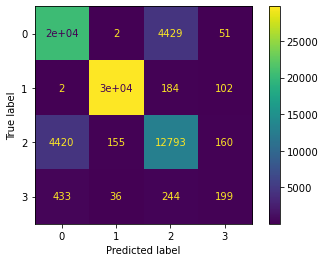

In [9]:
label = ['hospitalized', 'nonhospitalized','recovered', 'deceased']
va_pred = tuned_model.predict(va)
ev_va_report = classification_report(va_y, va_pred)
ev_va_accuracy = accuracy_score(va_y, va_pred)
ev_va_matrix = confusion_matrix(va_y, va_pred,labels=label)
print(ev_va_report)
ConfusionMatrixDisplay(ev_va_matrix).plot()

# 

### Attempts

In [ ]:
# Preprocess data
def process_data(name):
    file = r'../data/' + name + '.csv'
    print("processing file: {}".format(file))
    file = pd.read_csv(file,dtype=object)
    file.drop(columns=['land','Last_Update','province','country','source','additional_information'],inplace=True)
    file['date_confirmation'] = preprocessing.normalize([file['date_confirmation']])[0]
    return file
file = process_data("cases_train_preprocessed")

In [ ]:
# Train / Test split for model evaluation
def catboost_data(file):
    cat_feature=['sex','source','age_range_ind','age_range']
    text_feature = ['additional_information']

    df_tr, df_va = train_test_split(file, test_size=0.2, random_state = 1)

    df_tr_x = df_tr.drop(columns="outcome")
    df_tr_y = df_tr['outcome']


    df_va_x = df_va.drop(columns="outcome")
    df_va_y = df_va['outcome']

    return df_tr_x, df_tr_y, df_va_x, df_va_y
tr, tr_y, va, va_y = catboost_data(file)

In [ ]:
# label encode the target variable
tr_y = LabelEncoder().fit_transform(tr_y)
# summarize distribution
counter = Counter(tr_y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
x = tr
y = tr_y

In [ ]:
strategy = {0:50362 , 1:99933 , 2:119402 , 3:70362 }
oversample = SMOTE(sampling_strategy=strategy)

tr_y = LabelEncoder().fit_transform(y)
numerical = ['age', 'latitude', 'longitude','date_confirmation', 
             'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate', 'Case-Fatality_Ratio']
for i in numerical:
    x[i] = x[i].astype('float')
for i in x.columns:
    if i not in numerical:
        x[i] = x[i].astype('category')
        x[i] = x[i].cat.codes
        
tr, tr_y = oversample.fit_resample(x, tr_y)
counter = Counter(tr_y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

In [ ]:
# Specify catboost parameters
model = CatBoostClassifier(n_estimators=300, 
                            task_type="GPU",
                            devices='0:1',
                            learning_rate=0.2,
                            depth=12,
                            loss_function='MultiClass',
                            auto_class_weights = 'SqrtBalanced',
                            verbose = 100
                            )
df_tr_data = Pool(data = tr, label = tr_y)
model.fit(df_tr_data)

In [ ]:
# label encode the target variable
va_y = LabelEncoder().fit_transform(va_y)
numerical = ['age', 'latitude', 'longitude','date_confirmation', 
             'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate', 'Case-Fatality_Ratio']
for i in numerical:
    va[i] = va[i].astype('float')
for i in tr.columns:
    if i not in numerical:
        va[i] = va[i].astype('category')
        va[i] = va[i].cat.codes

In [ ]:
df_va_data = Pool(data = va,label = va_y)
tr_pred = model.predict(df_tr_data)
ev_tr_report = classification_report(tr_y, tr_pred)
print("Traning:")
print(ev_tr_report)

va_pred = model.predict(df_va_data)
ev_va_report = classification_report(va_y, va_pred)
print("Validation:")
print(ev_va_report)

# 

### DRAFT

In [ ]:
# # Specifying possible parameters of catboost - Grid Search
# grid = {'learning_rate': [0.2, 0.3, 0.4],
#         'depth': [10, 14],
#         'l2_leaf_reg': [0.0, 0.2],
#         'n_estimators':[100, 200, 400]
#        }

# # Specify catboost parameters
# cat_feature=['sex','source','age_range_ind','age_range']
# text_feature = ['additional_information']

# # Creating required scoring function
# scorer = {
#     'f1_macro' : make_scorer(f1_score, average='macro'),
#     'recall_macro': make_scorer(recall_score , average='macro'),
#     'accuracy': make_scorer(accuracy_score),
#     'recall_d' : make_scorer(recall_score,average=None,labels=['deceased']),
#     'f1_d' : make_scorer(f1_score, average=None, labels=['deceased']),
# }

# # Creating Catboost model
# model = CatBoostClassifier( task_type="GPU",
#                             devices='0:1',
#                             loss_function='MultiClass',
#                             auto_class_weights = 'SqrtBalanced',
#                             cat_features = cat_feature,
#                             text_features = text_feature)

# clf_grid = GridSearchCV(estimator=model, param_grid=grid, scoring=scorer, cv= 5, refit="f1_d", n_jobs=1, verbose=1)
# clf = clf_grid.fit(tr, tr_y)